In [2]:
from IPython.display import Markdown, display
display(Markdown(open("./SM_header.md", "r").read()))

Copyright © 2025-2026 Université Paris Cité

Author: [Guillaume Rousseau](https://www.linkedin.com/in/grouss/), Laboratoire Matières et Systèmes Complexes, UMR 7057, CNRS and Université Paris Cité, CNRS, UMR7057, 10 rue Alice Domon et Léonie Duquet, F-75013, Paris cedex 13, France (email: guillaume.rousseau@u-paris.fr)

This archive contains the supplemental materials and replication package associated with the preprint, "*Empirical Growing Networks vs Minimal Models: Evidence and Challenges from Software Heritage and APS Citation Datasets*", available on [arXiv](https://arxiv.org/abs/2501.10145) and [ssrn](http://ssrn.com/abstract=5191689).

**The latest version of the preprint (timestamped arXiv:2501.10145v5) is downloadable here https://arxiv.org/pdf/2501.10145**

The current version of the Python scripts and associated resources is available on the [author's GitHub page](https://github.com/grouss/growing-network-study).

This work is currently licensed under the [Creative Commons CC BY-NC-SA 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0).

To give appropriate credit and cite this work ([BibTeX entry](./rousseau2025temporal)):
Rousseau, G. (2025). *Empirical Growing Networks vs Minimal Models: Evidence and Challenges from Software Heritage and APS Citation
Datasets* [Preprint]. arXiv:2501.10145. https://arxiv.org/abs/2501.10145

 
# A) Replication Packages

[Open the Replication Package notebook related to the datasets.](./Replication_Package_Datasets.ipynb)

[Open the Replication Package notebook related to the figures.](./Replication_Package_Figures.ipynb)

# B) QuickStart Guide

[Open the QuickStart Guide notebook](./SM00_QuickStart.ipynb)

# C) Table of Contents

- 1. [Function Definitions](./SM01_Functions.ipynb)
- 2. [Dataset Import](./SM02_DatasetImport.ipynb)
- 3. [Building the Transposed Graph](./SM03_BuildingTransposedGraph.ipynb)
- 4. [Temporal Information Quality and Summary Statistics](./SM04_TemporalInformationMainStats.ipynb)
- 5. [Growth Relationship Between Nodes and Edges](./SM05_GrowingRules.ipynb)
- 6. [Topological Partitioning($RV$ Nodes)](./SM06_TopologicalPartitioning.ipynb)
- 7. [In-Degree and Out-Degree Distributions Over Time](./SM07_DegreeDistributionOverTime.ipynb)
- 8. [Distribution Tail Analysis](./SM08_DistributionTailAnalysis.ipynb)
- 9. [Temporal Partitioning](./SM09_TemporalPartitioning.ipynb)
- 10. [Building the temporal graph $O-(RV/RL)-O$](./SM10_DerivedGrowingNetwork.ipynb)
- 11. [Building the $TSL$ graph](./SM11_TSLPartitioning.ipynb)
- 12. [Price / Directed Barabási–Albert Model Use Case](./SM12_BarabasiAlbertUseCase.ipynb)
- 13. [APS citation network](./SM13_APSCitationNetwork.ipynb)
- 14. [Generic Report Template](./SM14_GenericReport.ipynb)


**NB :** As of 2026/01/31, the QuickStart guide, the replication packages, and SM01 to SM14 are available. The Python scripts are also provided under local_utils directory, but they are not in their final form and should be considered an alpha release.

The graphs used in the study are available in a distinct Zenodo Deposit 10.5281/zenodo.15260640 ($\sim50$ Go), including the main graph (2+ billions of nodes, $\sim4$ billions of edges), and two derived graphs ($\sim150$ millions nodes and edges).

The APS Citation Dataset (2022 export) has been included in the study.

More release notes are available in the [dedicated notebook](./SM_ReleaseNote.ipynb).

In [2]:
%load_ext autoreload
%autoreload 2

import importlib,sys,local_utils
from local_utils import *

print("___ Import data from graphpath=",config.graphpath)
print("___ Export data to exportpath=",config.exportpath)   
DisplayCopyrightInfo()


___ Import data from graphpath= ./ImportData/
___ Export data to exportpath= ./ExportData/
--------------------------------------------------------------------------------
Copyright 2025 Université Paris Cité, France 
Author: Guillaume Rousseau, MSC Lab, Physics Department, Paris, France 

(https://www.linkedin.com/in/grouss/)

This archive contains the supplemental materials and replication package associated with the preprint available on :
- arXiv (https://arxiv.org/abs/2501.10145)
- SSRN  (http://ssrn.com/abstract=5191689

Current version of python scripts and associated ressources are available on author's github page
(https://github.com/grouss/growing-network-study)

This work is currently licensed under CC BY-NC-SA 4.0
(https://creativecommons.org/licenses/by-nc-sa/4.0)
--------------------------------------------------------------------------------



---

# 0. Quick Start Guide

In the scope of this QuickStart guide, we present the main steps involved in the analysis of the main $O/RV/RL-RV/RL$ graph, the derived $O-(RV/RL)-O$ graph obtained through temporal and topological partitioning, and a subsequent comparison using a synthetic dataset generated with an implementation of the Barabási-Albert model.


## a) Dataset Structure

### Nodes and eges representation

`nodes` is an array of size `Nnodes`+1

Indexes of target nodes of a source node of index `i` is the array `edges[nodes[i]:nodes[i+1]]`

If the size of this table is zero, this node has no descendants and is a leaf.

Since the number of nodes and edges is less than $2^{32}-1$ for the datasets used in this study (and in almost all study based on real-world dataset), one-dimensional numpy arrays of type `uint32` are sufficient to store this graph and its associated transposed graph.

The graph structure (ie `nodes` and `edges` array), along with the timestamps array (which uses the same amount of memory as `nodes`), requires $8.3 \times 2 + 14.3 = 31$ GB. 

If the graph (`nodes` and `edges`), timestamps (`nodesad`), and transposed graph need to be accessed simultaneously, the memory requirement increases to $8.3 \times 3 + 14.3 \times 2 = 53.5$ GB.

This Compressed Sparse Row (CSR, https://en.wikipedia.org/wiki/Sparse_matrix) representation is highly efficient for traversing a graph in the forward direction, as it allows for the quick retrieval of adjacent node indices.

In practice, this representation is efficient for very large sparse graph, and even for large dense graph.

Other representations are possible and may be better suited for certain types of graph studies (ie for the study of most common graph/network properties), but this point falls outside the scope of this study.



### Encoding of node and edge types


In the main dataset used in this study, nodes can have one of the 3 following type: `Origin`, `Release` or `Revision`.

Edges' types are dedined by their source and target nodes's type. 

We assume directed/oriented edges by default. 

In this study, we use implicit definition of the type of a node, based on ordering of nodes in the numpy array `nodes`. 

Generalization to undirected edges, arbitrary edge or nodes types, can be done using extra numpy array using implicit node/edge indexings from the corresponding numpy array (ie `nodes`and `edges`). This is not supported for the moment, but in practise, simple work around are possible (see below the discussion about of the different between in-degre/out-degree distributions and (unidirected) degree distributions.)

It means that in the graph representation used here 

- Nodes with index such that $d['OindexMin'] <= index <= d['OindexMax']$ are Origin nodes.
- Nodes with index such that $d['RLindexMin'] <= index <= d['RLindexMax']$ are Release nodes.
- Nodes with index such taht $d['RVindexMin'] <= index <= d['RVindexMax']$ are Revision nodes.

The type of a node, knowing its index, is simply returned by the `GetNodesType` function


### Timestamp/temporal information encoding

In our dataset, timestamps correspond to the author commit dates. They are stored in a dedicated array of `uint32` corresponding to the numbers of second since `EPOCH` (1970/01/01 00:00 UTC).

Timestamps before `EPOCH` are set to 0.

Timestamps after Sunday, February 7, 2106, at 06:28:15 AM UTC are set to $2^{32} - 1 = 4,294,967,295$, which is the largest integer that can be represented using a uint32.

Unknown timestamps (e.g., for origin nodes in the O/RV/RL-O/RV/RL dataset) are set to $2^{32}-1$.


## b) Loading datasets

We provide two functions to load the different datasets provided in the replication package of the study (or on request sending email to the author)

### Main graph $\{O/RV/RL\}-\{RV/RL\}$

In [7]:
# Loading the main graph O/RV/RL-RV/RL
# Over 2 billion nodes and approximately 4 billion edges

# Note: Loading and computing basic statistics 
# on this very large graph can take 1 to 2 minutes 
# on a regular laptop. All cells can be executed without 
# issues on a 2019 MacBook Pro with 64 GB of RAM.

FlagRunLargeGraph=False
if FlagRunLargeGraph:
    nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName=LoadAllArray()  
    statoutput=DisplayTypeStats(nodes,edges,d)    


In [8]:
# GetNodesType function return node type
if FlagRunLargeGraph:
    for ntype in ["O","RL","RV"]:
        for i in np.random.randint(d[ntype+"indexMin"],d[ntype+"indexMax"]+1,4):
            print(f'The node of index {i:15,} is of type {GetNodesType(i):<}')
        print()

### Derived temporal graph $O-(RL/RV)-O$

In [9]:
# Loading the derived dataset O-(RV/RL)-O  
# ~140 millions of nodes, ~155 millions of edges)

nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName=LoadAllArray_OO()
statoutput=DisplayTypeStats(nodes,edges,d)    


Loaded : nodes_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : edges_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : nodesadderived_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : ./ImportData/d_o_derived_O-RVRL-O_BigO_20240429.pkl
DatasetName SWH derived O-[RV/RL]-O
DatasetDescription Zenodo Deposit 10.5281/zenodo.15260640
DatasetDoi 10.5281/zenodo.15260640
From EPOCH 1970-01-01
GetNodesTypesArray [Elapse time : 1.0 (s)]
___ O     :     139,524,533 (100.0%)
____________________________________
___ Total :     139,524,533 (100.0%)

GetEdgesTypesArray [Elapse time : 1.0 (s)]
___ O>O   :     156,682,302 (100.0%)
____________________________________
___ Total :     156,682,302 (100.0%)



In [11]:
# The GetNodesType function always return O for nodes of the O-(RV/RL)-O graph
for i in np.random.randint(0,len(nodes),4):
    print(f'The node of index {i:15,} is of type {GetNodesType(i):<}')

The node of index      68,274,426 is of type O
The node of index      37,382,762 is of type O
The node of index      77,091,362 is of type O
The node of index      63,720,833 is of type O


In [12]:
# Displaying stat associated to the TSL encoding of the  O-(RV/RL)-O  graph
# using the depth argument
nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName=LoadAllArray_OO()  
statoutput=DisplayTypeStats(nodes,edges,d,depth=1)    


Loaded : nodes_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : edges_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : nodesadderived_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : ./ImportData/d_o_derived_O-RVRL-O_BigO_20240429.pkl
DatasetName SWH derived O-[RV/RL]-O
DatasetDescription Zenodo Deposit 10.5281/zenodo.15260640
DatasetDoi 10.5281/zenodo.15260640
From EPOCH 1970-01-01
GetNodesTypesArray [Elapse time : 5.0 (s)]
___ 000   :      20,324,807 (14.57%)
___ 001   :      56,686,555 (40.63%)
___ 010   :      43,251,437 (31.0%)
___ 011   :      10,751,627 (7.71%)
___ 101   :       7,077,940 (5.07%)
___ 111   :       1,432,167 (1.03%)
____________________________________
___ Total :     139,524,533 (100.0%)

GetEdgesTypesArray [Elapse time : 10.0 (s)]
___ 010>101 :      40,575,330 (50.26%)
___ 010>111 :      20,758,012 (25.71%)
___ 011>101 :       9,563,353 (11.85%)
___ 011>111 :       6,990,240 (8.66%)
___ 111>101 :       1,292,161 (1.6%)
___ 111>111 :       1,554,917 (1.93%)
_______________

## c) Studying Temporal Statistics

One of the methodological points raised and discussed in this study on growing networks is the importance of temporal information, in order to study — when possible — the dynamics of the network over time.

A first step may be to assess the quality of this temporal information, by identifying, for each type of node and edge, the proportion of timestamps that correspond to the two extreme values: January 1, 1970, and February 7, 2106.

Here, is an example analyzing the temporal statistics of the derived $O-(RV/RL)-O$ graph.

In [13]:
nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName=LoadAllArray_OO()

Loaded : nodes_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : edges_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : nodesadderived_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : ./ImportData/d_o_derived_O-RVRL-O_BigO_20240429.pkl
DatasetName SWH derived O-[RV/RL]-O
DatasetDescription Zenodo Deposit 10.5281/zenodo.15260640
DatasetDoi 10.5281/zenodo.15260640
From EPOCH 1970-01-01


In [14]:
# Exception Timestamp nodes per type
arraytype,encoding=GetNodesTypesArray(nodes,edges,d)
DisplayTimestampException(arraytype,encoding,nodesad,f'Nodes')
    
print(f'_'*80)
    
# edge source timestamp exception
arraytype,encoding=GetEdgesTypesArray(nodes,edges,d)
arrayTS=GetSourceEdgeTimeStamp(nodes,edges,nodesad,d)
DisplayTimestampException(arraytype,encoding,arrayTS,f'Source Edges')
    
print(f'_'*80)
    
# edge target timestamp exception
arraytype,encoding=GetEdgesTypesArray(nodes,edges,d)
arrayTS=GetTargetEdgeTimeStamp(nodes,edges,nodesad,d)
DisplayTimestampException(arraytype,encoding,arrayTS,f'Target Edges')

Nodes        Timestamp Exceptions O     | Total=    139,524,533 | Zero(1970-01-01)=          1,384 | Ts(1970-01-01+2^32-1)=     63,601,527 |
________________________________________________________________________________
Source Edges Timestamp Exceptions O>O   | Total=    156,682,302 | Zero(1970-01-01)=          1,812 | Ts(1970-01-01+2^32-1)=     61,360,197 |
________________________________________________________________________________
Target Edges Timestamp Exceptions O>O   | Total=    156,682,302 | Zero(1970-01-01)=        155,293 | Ts(1970-01-01+2^32-1)=         28,287 |


Nodes with timestamp exceptions represent approximately 45% (63.6 / 139.5) of the total number of nodes in the $O-(RV/RL)-O$ dataset. These mainly correspond to nodes without release or revision dates after partitioning, for which $nodesad = 2^{32} - 1$ .

Approximately 60% (61.4 / 156.7) of the edges exhibit timestamp exceptions, i.e., their source or target nodes have a timestamp exception. It mainly correspond to edges linking source node without release or revision nodes after partitioning, to a target node for which timestamp do not lead to an exception. 

### For nodes

In [15]:
nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName=LoadAllArray_OO()
# Build TS array of all nodes 
print(80*"-")
# Exclude edges where timestamp==0 or timestamp==2**32-1
ti=time.time()
maskNodesTS=np.logical_and(nodesad!=0,nodesad!=2**32-1)
tf=time.time()
print("Mask Building ",np.round(tf-ti,2),"(s)")
valid_nodes=np.sum(maskNodesTS)
print(f'{valid_nodes:,} valid nodes over a total of {Nnodes:,} i.e. {np.round(valid_nodes/Nnodes*100,2)} % of valid nodes')
print(80*"-")

# ! Timestamp are uint32 (must be converted to int before doing the diff)
# deltaTS still in second (negative or positive)
ti=time.time()
nodesarrayTS=nodesad[maskNodesTS]
tf=time.time()
print("Building nodesarrayTS ",np.round(tf-ti,2),"(s)")

# convert s since EPOCH to Months since EPOCH
ti=time.time()
nodesarrayTS=timestampsarray2yearmonth(nodesarrayTS)
tf=time.time()
print("Applying Mask ",np.round(tf-ti,2),"(s)")

ti=time.time()
arraytype,encoding=GetNodesTypesArray(nodes,edges,d)
arraytype=arraytype[maskNodesTS]
tf=time.time()
print("Building node type array and applying mask",np.round(tf-ti,2),"(s)")
print(80*"-")

Loaded : nodes_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : edges_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : nodesadderived_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : ./ImportData/d_o_derived_O-RVRL-O_BigO_20240429.pkl
DatasetName SWH derived O-[RV/RL]-O
DatasetDescription Zenodo Deposit 10.5281/zenodo.15260640
DatasetDoi 10.5281/zenodo.15260640
From EPOCH 1970-01-01
--------------------------------------------------------------------------------
Mask Building  0.06 (s)
75,921,622 valid nodes over a total of 139,524,533 i.e. 54.41 % of valid nodes
--------------------------------------------------------------------------------
Building nodesarrayTS  0.64 (s)
Applying Mask  0.42 (s)
Building node type array and applying mask 0.61 (s)
--------------------------------------------------------------------------------


Start for node type : O
--------------------------------------------------------------------------------


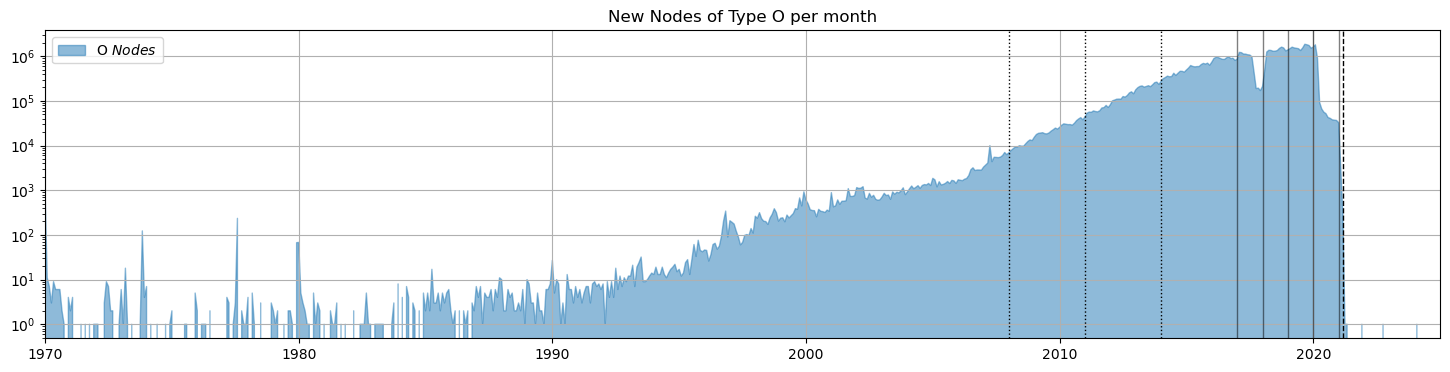

--------------------------------------------------------------------------------


In [19]:
for i,Ntype in enumerate(encoding):
    mask_type=arraytype==i 
    if np.sum(mask_type)!=0: # only for edge types that exist
        print("Start for node type :",Ntype)
        print(80*"-")
        PlotTSoverTimeNodes(nodesarrayTS[mask_type],Ntype)
        print(80*"-")

There is no reason to assume that the growth dynamics of the number of nodes follow a trivial function of time. This view provides a first insight into the overall behavior. One can observe the exponential growth in the number of new nodes per month, along with two major anomalies characterized by a deficit in new nodes: one from early 2020 to the dataset’s export date, and another around the end of 2017.

These anomalies are present in the export of the Software Heritage project used to build the main graph ($O/RL/RV–RL/RV$) and its derived graph ($O–(RL/RV)–O$). They are not artifacts resulting from the construction of the datasets studied here.
The presence of such anomalies is not uncommon in real-world datasets. It is, of course, important to account for their potential impact when interpreting the results of the analyses conducted (see the more detailed discussion in *SM04_TemporalInformationMainStats.ipynb*).


### For edges

In [20]:
nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName=LoadAllArray_OO()

Loaded : nodes_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : edges_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : nodesadderived_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : ./ImportData/d_o_derived_O-RVRL-O_BigO_20240429.pkl
DatasetName SWH derived O-[RV/RL]-O
DatasetDescription Zenodo Deposit 10.5281/zenodo.15260640
DatasetDoi 10.5281/zenodo.15260640
From EPOCH 1970-01-01


In [22]:
arraytype,encoding,sourcearrayTS,targetarrayTS,deltaTS=GetEdgeTs(nodes,edges,nodesad,d,Nnodes,Nedges)

--------------------------------------------------------------------------------
Edge Source/Target TS Building  2.12 (s)
Mask Building  0.13 (s)
95,293,525 valid edges over a total of 156,682,302 i.e. 60.82 % of valid edges
--------------------------------------------------------------------------------
Building DeltaTS  1.28 (s)
Applying Mask  1.03 (s)
Building edge type array and applying mask 0.69 (s)
--------------------------------------------------------------------------------


Start for edge type : O>O
--------------------------------------------------------------------------------


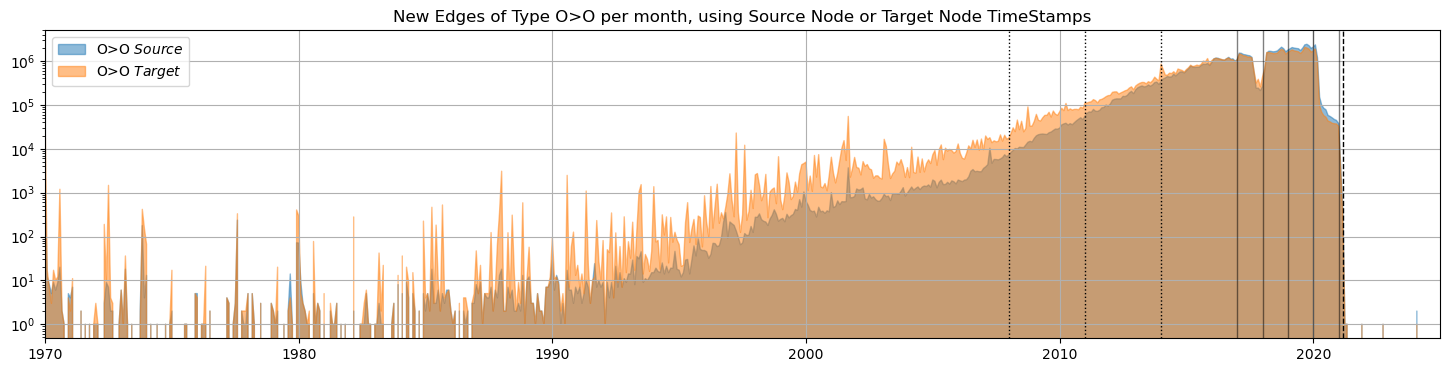

             TS <= -10 Years           1,398 i.e   0.00 %
-10 Years <  TS <= - 1 Year           78,240 i.e   0.08 %
- 1 Year  <  TS <= - 1 Month         130,389 i.e   0.14 %
- 1 Month <  TS <= - 1 Week           51,310 i.e   0.05 %
- 1 Week  <  TS <= - 1 Day            38,572 i.e   0.04 %
- 1 Day   <  TS <= - 1 Hour           21,000 i.e   0.02 %
- 1 Hour  <  TS <= - 1 Mn              8,033 i.e   0.01 %
- 1 Mn    <  TS <= - 1 S               2,027 i.e   0.00 %
................................................................................
O>O     Total TS <  0 S (negative)         330,969 i.e   0.35 %
................................................................................
O>O     ***** TS == 0 S (null)          75,975,756 i.e  79.73 %
................................................................................
O>O     Total TS >  0 S (positive)      18,986,800 i.e  19.92 %
................................................................................
  1 S     <= TS <   

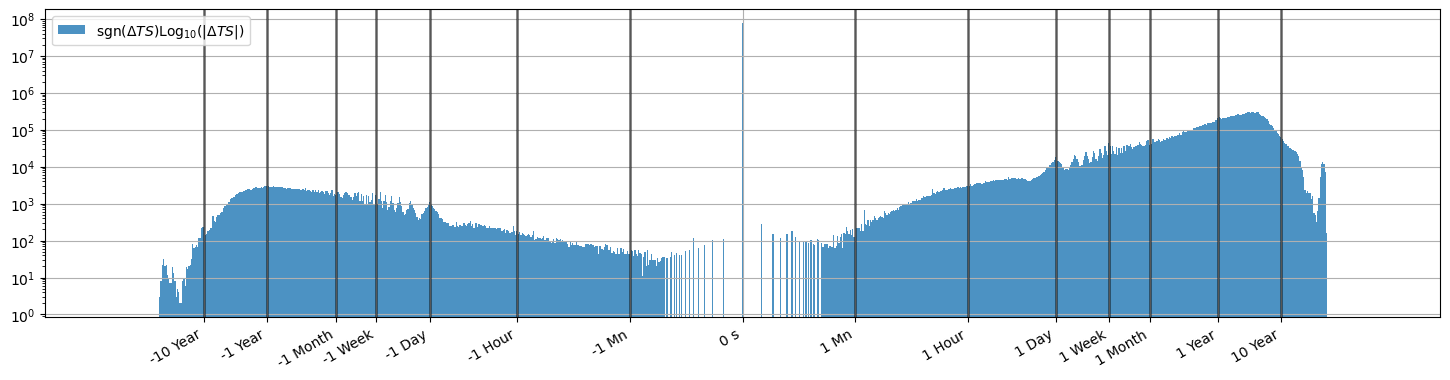

End for edge type : O>O
--------------------------------------------------------------------------------


In [24]:
for i,Etype in enumerate(encoding):
    mask_type=arraytype==i 
    if np.sum(mask_type)!=0: # only for edge types that exist
        print("Start for edge type :",Etype)
        print(80*"-")
        PlotTSoverTimeEdges(sourcearrayTS[mask_type],targetarrayTS[mask_type],Etype)
        DisplayTSstat(deltaTS[mask_type],Etype)
        PlotTSHisto(deltaTS[mask_type],Etype)
        print(80*"-")


Particular attention is given here to the temporal information characterizing the conditions under which edges appear.
Since no specific timestamps are available for the edges themselves, we rely on the creation dates of the source and target nodes.
It is also assumed that edges are created once and remain unchanged over time.

This representation reveals certain temporal characteristics of the derived graph under study.
We observe a significant concentration of edges where the time difference between the creation of the source and target nodes is zero. These correspond to edges associated with self-loops.

The time difference can be either positive or negative, indicating that the underlying evolution rules allow the creation of edges from a node to another that appears later in time.
This point is particularly important for drawing analogies with one or more minimal models considered relevant.

We also note the presence of specific regions of high density, such as those corresponding to multiples of 24 hours (i.e., multiples of $24h\times 3600s \approx 10^5 s$).

## d) Build in/out degree distributions of the temporal graph $O-(RL/RV)-O$



The study of minimal models shows that, in some cases, the in-degree distribution 
tends toward a power law for large degree values $\delta_{in}$. 

According to Clauset et al., 
we can then attempt to estimate the most likely exponent $\hat{\alpha}$ (MLE) (or $\hat{e}$ in the article) for all possible cutoff 
values $x_{c}$, assuming that it belongs the parametric family 
$pdf(x)\propto x^{-\alpha}$ for $x\ge x_{c}$.
Among these possible cutoffs, the value $x_c^{min}$ for which the observed 
distribution is closest to the distribution associated with the estimated exponent 
$\hat{\alpha}(x_{c})$ can be determined using the Kolmogorov-Smirnov distance, 
and is used as best cutoff value $x_c^{min}$.

Here, we display the in-degree distribution along with information from Clauset et al.’s estimation of the scaling factor associated with the tail of the distribution, assuming that the "tail" belongs to the parametric family of power-law distributions with scaling exponent $\alpha$.

In [29]:
nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName=LoadAllArray_OO()

Loaded : nodes_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : edges_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : nodesadderived_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : ./ImportData/d_o_derived_O-RVRL-O_BigO_20240429.pkl
DatasetName SWH derived O-[RV/RL]-O
DatasetDescription Zenodo Deposit 10.5281/zenodo.15260640
DatasetDoi 10.5281/zenodo.15260640
From EPOCH 1970-01-01


yearts 1,608,336,000 (s)
Before applying restriction based on edges creation date, # edges 156,682,302
After  applying restriction based on edges creation date, # edges 95,262,818


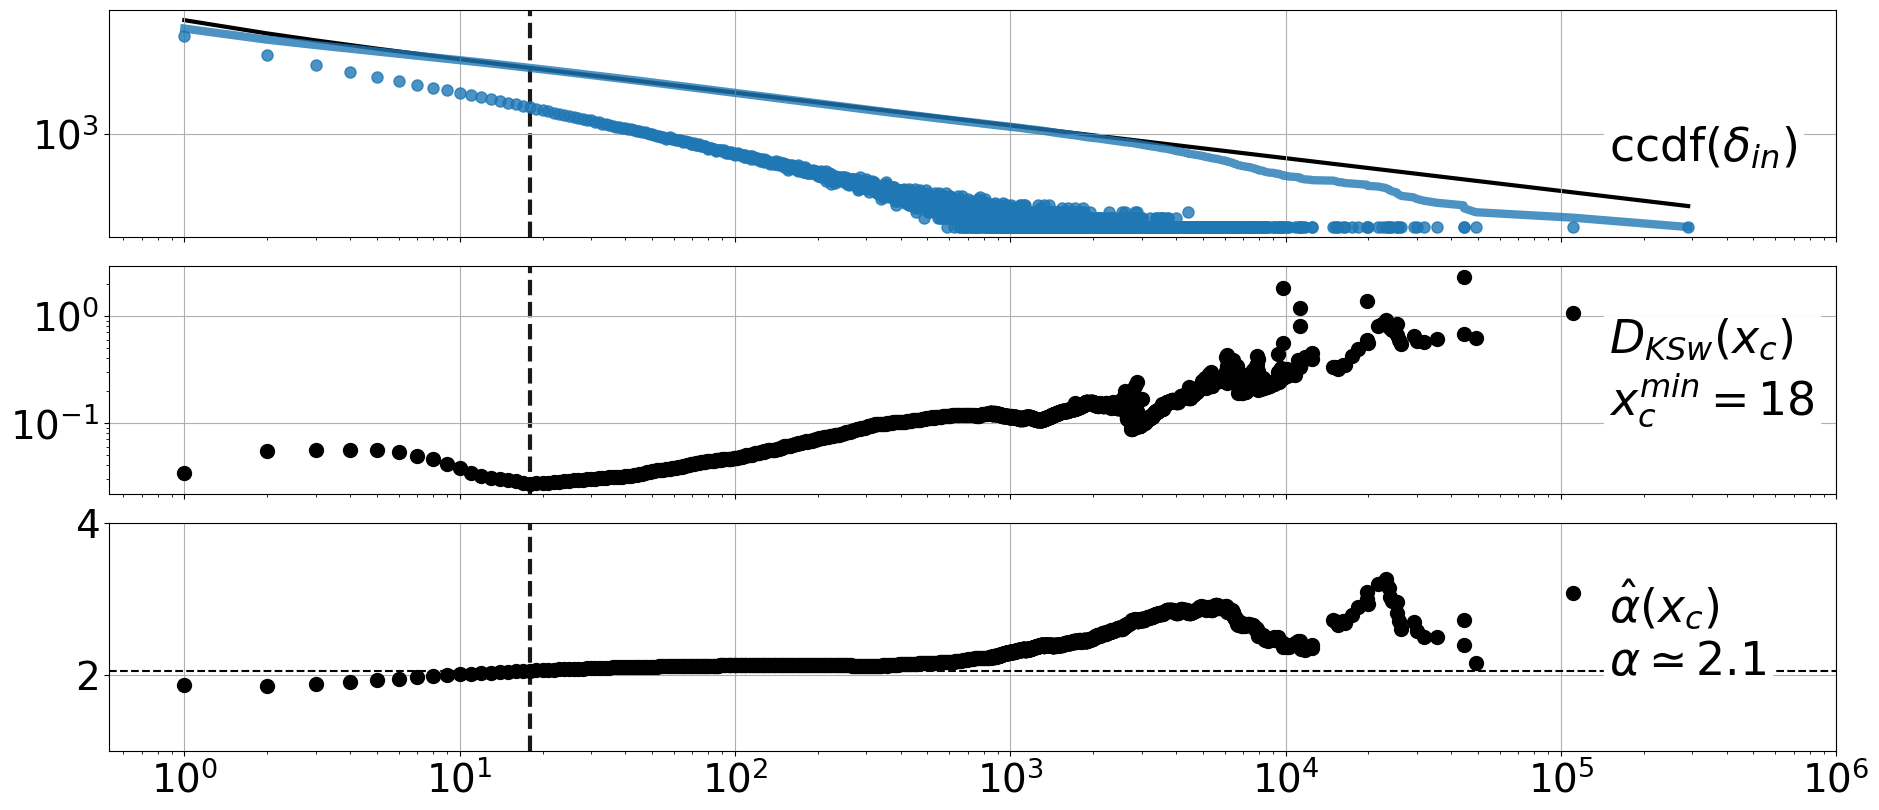

In [30]:
year=2021
RemoveSelfLoop=True
yearts=(year-1970)*365*24*60*60 # simplified definition used in the scope of this QuickStart Guide only
print("yearts",f'{yearts:,} (s)')
sourceedges=GetSourceEdge(nodes)
TSsourceedges=nodesad[sourceedges]
TStargetedges=nodesad[edges]
print(f'Before applying restriction based on edges creation date, # edges {Nedges:,}')
mask=np.logical_and(TSsourceedges<=yearts,TStargetedges<=yearts)
#mask=TSsourceedges<=yearts
print(f'After  applying restriction based on edges creation date, # edges {np.sum(mask):,}')
if RemoveSelfLoop:
    # excluding self-loop
    mask=np.logical_and(mask,sourceedges!=edges)
    din=np.bincount(edges[mask],minlength=Nnodes)
din=np.bincount(edges[mask],minlength=Nnodes)
y=np.bincount(din)
x=np.arange(len(y))
mask=np.logical_and(y!=0,x!=0)
y=y[mask]
x=x[mask]
ccdf=np.cumsum(y[::-1])[::-1]
WKS="weightedKS" # weightedKS, KS,Kuiper
XCmin=6
Plot_Figure_Degree(x,y,ccdf,WKS=WKS,XCmin=XCmin,height=4,yrangeAlpha=[1,4])



The method proposed by Clauset et al. cannot be used as a black box.

A value of $\hat{\alpha}(x_c)$ that remains relatively constant over a range of $x_c$ values would be an interesting feature, as it would support the idea that the results are not overly sensitive to the precise value chosen to define the beginning of the distribution’s tail. This is not the case here.

Note: It should be kept in mind that the method proposed by Clauset et al. makes an a priori assumption that the tail of the distribution follows a power-law. Therefore, it cannot be used to draw conclusions regarding the existence of a scale-free regime without additional discussion or argumentation.


## e) Graph partitioning

### Topological Partitioning

The question addressed by the topological partitioning is whether nodes with distinct topological properties follow different evolution rules.

Here is a simple example illustrating the relevance of this approach for studying the evolution rules of the subgraph composed of `RV` nodes, extracted from the complete $O/RL/RV–RL/RV$ dataset.

In [31]:
nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName=LoadAllArray()
del edges # not used in this example

Loaded : ./ImportData/nodes_20240310.pkl
Loaded : ./ImportData/edges_20240310.pkl
Loaded : ./ImportData/nodesad_20240310.pkl
Loaded : ./ImportData/d_20240310.pkl
DatasetName SWH derived (O/RL/RV)-(RL/RV)
DatasetDescription Zenodo Deposit 10.5281/zenodo.15260640
DatasetDoi 10.5281/zenodo.15260640
From EPOCH 1970-01-01


In [32]:
dout=nodes[1:]-nodes[:-1]
mask_dout=dout>=2 # ! nodes with 2 or more outgoing edges at the time the dataset was exported 
del dout
mask_RV=np.zeros(Nnodes,dtype='bool')
mask_RV[d["RVindexMin"]:d["RVindexMax"]+1]=True # restriction to RV nodes
mask_RV_dout=np.logical_and(mask_RV,mask_dout)

In [34]:
# Create an array for nodes where the timestamp (in seconds since the epoch)
# is converted to the number of months since the epoch.
# This step can take several dozen seconds.
nodesTS=timestampsarray2yearmonth(nodesad)

In [35]:
h_full=np.bincount(nodesTS[mask_RV])

In [36]:
h_dout=np.bincount(nodesTS[mask_RV_dout])

In [37]:
# restriction to 1970-2070
h_full=h_full[:12*1000]
h_dout=h_dout[:12*1000]

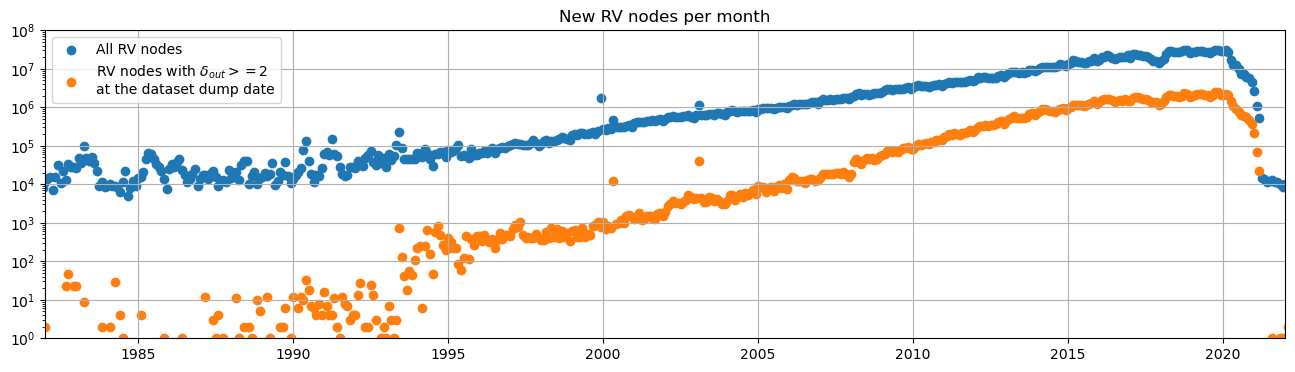

In [38]:
xrange=np.arange(len(h_full))/12+1970
plt.figure(figsize=(16,4))
plt.title("New RV nodes per month")
plt.scatter(xrange,h_full,label="All RV nodes")
plt.scatter(xrange,h_dout,label=r'RV nodes with $\delta_{out}>=2$'+'\n'+'at the dataset dump date')
plt.xlim((1982,2022))
plt.ylim((1e0,1e8))
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()


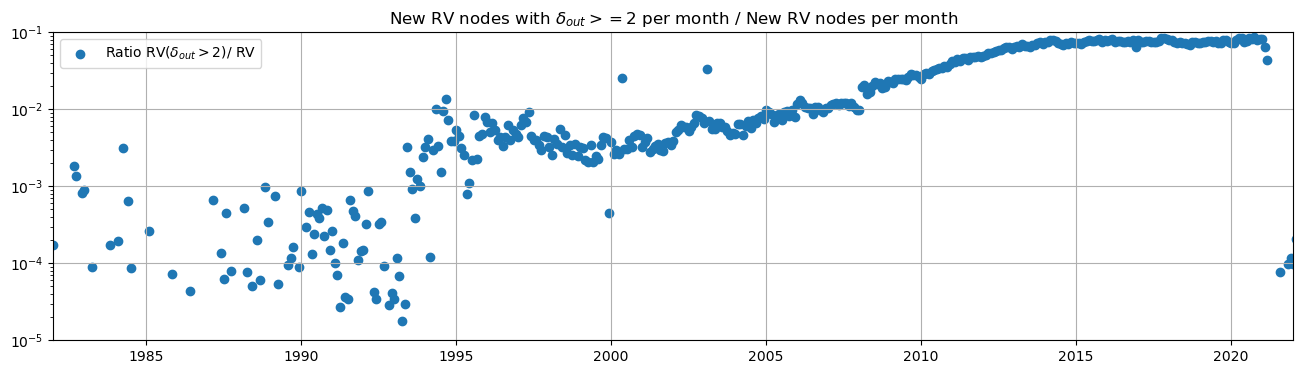

In [39]:
xrange=np.arange(len(h_full))/12+1970
plt.figure(figsize=(16,4))
plt.title(r'New RV nodes with $\delta_{out}>=2$ per month'+" / New RV nodes per month")
plt.scatter(xrange,h_dout/h_full,label=r'Ratio RV($\delta_{out}>2$)/ RV')
plt.xlim((1982,2022))
plt.ylim((1e-5,1e-1))
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

Partitioning the `RV`nodes into subcategories based on their topological characteristics (in this case, the number of outgoing edges at the time of export) highlights several distinct regimes over time.

In this dataset, we observe that:
- Starting in 2005 (or possibly as early as the early 2000s), there is an increase in the proportion of `RV` nodes with two or more outgoing edges. This can reasonably be linked to the rapid diffusion and adoption of distributed version control systems such as Git, with a complete transition observed after 2014 (the ratio becomes more or less constant).
- From 1994 to 2005, there was limited creation of revision nodes with two or more outgoing edges (representing less than $1\%$ of the total number of new nodes per month), potentially related to the import or migration from one version control system to another.

A noticeable change is also observed in 2008, likely associated with the launch of the GitHub platform.

Discussing whether this represents a change in the network evolution rules (external cause) or a competition between two distinct evolution mechanisms (internal cause) requires a detailed analysis of the network dynamics associated with the origin nodes.


### TSL Partitioning

To go further and generalize the topological partitioning introduced while studying the $RV−RV$ subnetwork, we introduce a `TSL` 
classification based on the topological properties of the derived growing network $O−(RV/RL)−O$. In this classification, each node is characterized by the number of incoming degrees $T$, the number of outgoing degrees S, and a boolean $L$ which equals $1$ if it links to itself, and $0$ otherwise. Self-loops exist for origin nodes that have one or more $RV/RL$ nodes after partitioning. We also introduce the classification depth $\delta_{max}$, which corresponds to the maximum value of T and S used to define nodes types and partition the origin nodes.


In the scope of this QuickStart notebook, we demonstrate how to build the in-degree distribution of origin nodes of the derived growing network $O−(RV/RL)−O$ that have a self-loop, at least one incoming edge from another node ($T = 1$), and at least one outgoing edge to another node ($S = 1$).

This corresponds to the in-degree distribution of the node with $TSL = 111$ in the subgraph $011/010$–$111$–$101/111$, noting that source nodes may have different $TSL$ types.

In [40]:
# loading the derived network
#nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName=LoadAllArray_OO(keypath="L0")
nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName=LoadAllArray_OO(keypath="BigO")

Loaded : nodes_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : edges_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : nodesadderived_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : ./ImportData/d_o_derived_O-RVRL-O_BigO_20240429.pkl
DatasetName SWH derived O-[RV/RL]-O
DatasetDescription Zenodo Deposit 10.5281/zenodo.15260640
DatasetDoi 10.5281/zenodo.15260640
From EPOCH 1970-01-01


In [41]:
depth=1
statsoutput=DisplayTypeStats(nodes,edges,d,depth=1)

GetNodesTypesArray [Elapse time : 5.0 (s)]
___ 000   :      20,324,807 (14.57%)
___ 001   :      56,686,555 (40.63%)
___ 010   :      43,251,437 (31.0%)
___ 011   :      10,751,627 (7.71%)
___ 101   :       7,077,940 (5.07%)
___ 111   :       1,432,167 (1.03%)
____________________________________
___ Total :     139,524,533 (100.0%)

GetEdgesTypesArray [Elapse time : 10.0 (s)]
___ 010>101 :      40,575,330 (50.26%)
___ 010>111 :      20,758,012 (25.71%)
___ 011>101 :       9,563,353 (11.85%)
___ 011>111 :       6,990,240 (8.66%)
___ 111>101 :       1,292,161 (1.6%)
___ 111>111 :       1,554,917 (1.93%)
____________________________________
___ Total :      80,734,013 (100.0%)

GetEdgesTypesArray Self Loop [Elapse time : 10.0 (s)]
001=001      56,686,555 (74.64%)
011=011      10,751,627 (14.16%)
101=101       7,077,940 (9.32%)
111=111       1,432,167 (1.89%)
______________________________
___ Total :      75,948,289 (100.0%)



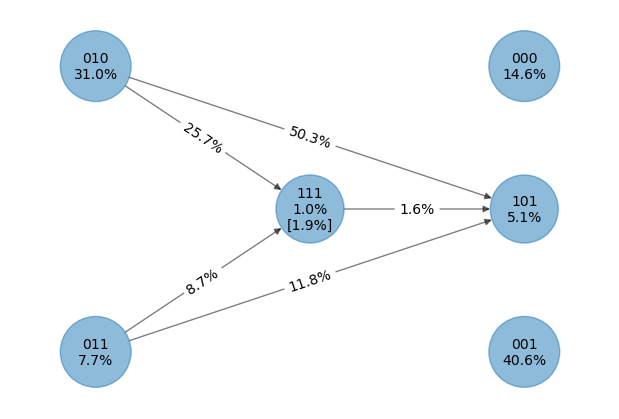

In [42]:
DisplayTSLGraph_Delta_1({depth:statsoutput})


Identifying the existence of subtypes governed by distinct network evolution rules in real-world systems is very important.

This is particularly relevant due to convolution effects between distributions of different nature, associated with various types and subtypes—whether explicitly labeled or not in the original dataset.

## f) Application to synthetic graph (modified Barabási-Albert/Price model)

The objective here is to demonstrate how the proposed methodology can be applied to synthetic data generated from a minimal model (in this case, a directed Barabási–Albert/Price model), with the aim of facilitating comparisons between real-world network data and minimal models that have provided a theoretical framework for over two decades.

In [44]:
n=int(1e7) # number of nodes
m=2 # number of new edges per new nodes
nodesBA,edgesBA,NnodesBA,NedgesBA,SelfLoopBA=BarabasiAlbertGraph(n,m,Verbose=True,seed=42)

Elapse 12.42328405380249


The Barabási–Albert and the Price models do not define explicit temporal information for nodes and edges. We assigned timestamps between 1970 and 2021, assuming an exponential growth in the number of nodes, solely to facilitate comparison with the previous dataset. The original node creation order is preserved.

In [45]:
# define d using same type of nodes to ease comparison

dBA=SetParamsBA_d(NnodesBA)
nodesadBA=SetParamsBA_nodesad(NnodesBA)


### in/out degree distributions

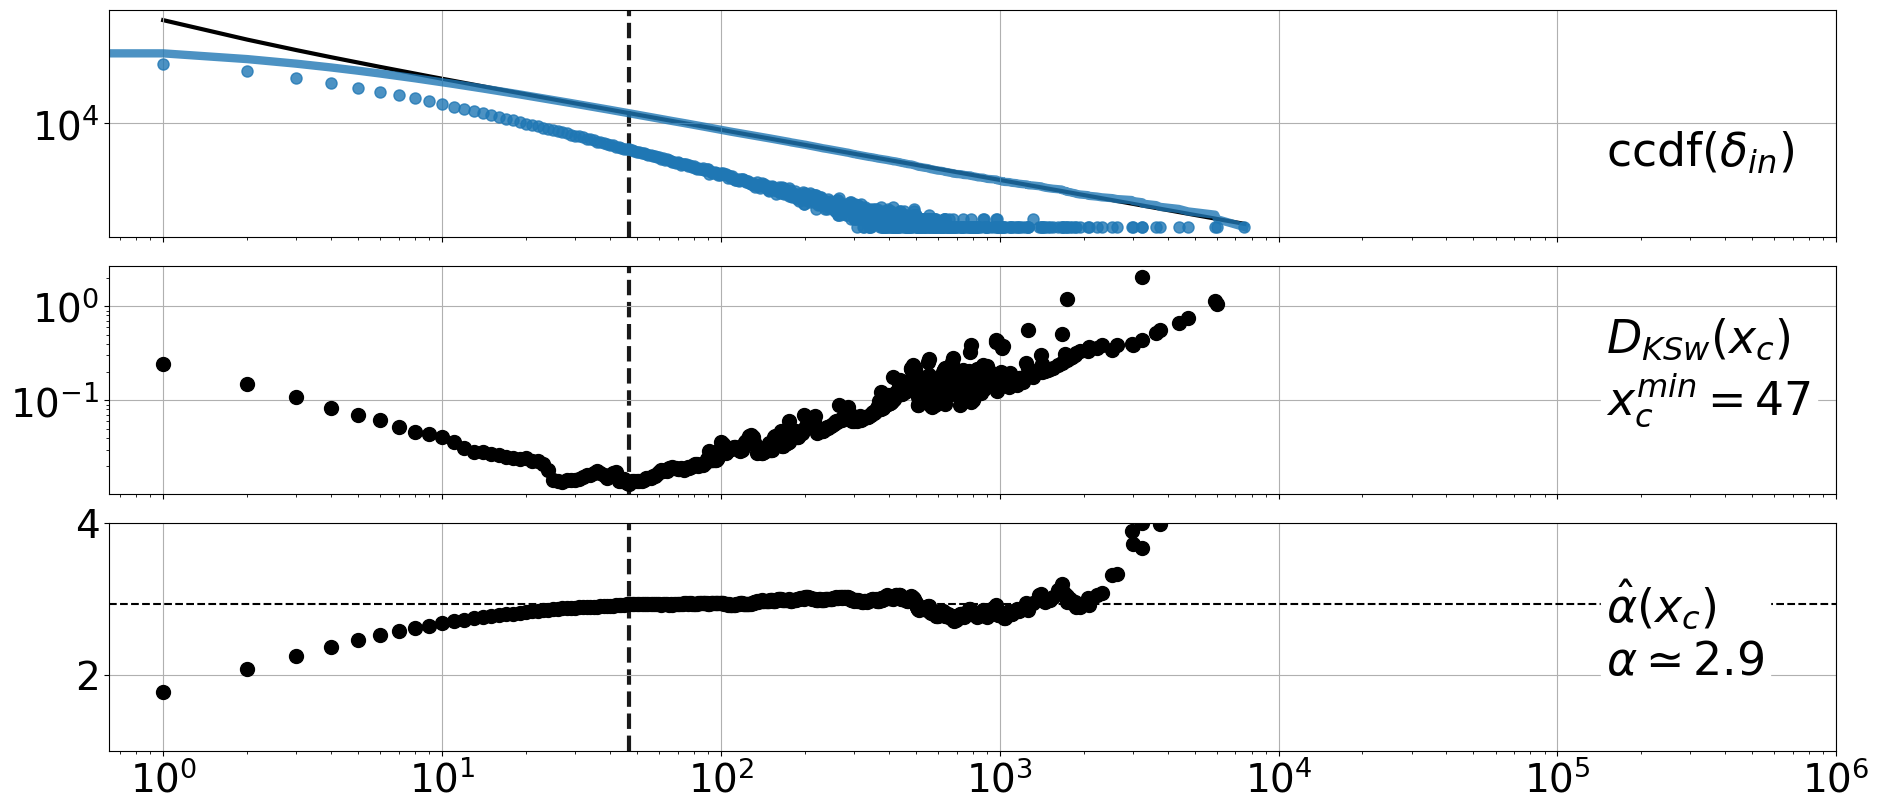

In [46]:
answer=GetXYhist(edgesBA,NnodesBA)
x=answer["x"]
y=answer["y"]
ccdf=answer["ccdf"]
Plot_Figure_Degree(x,y,ccdf,yrangeAlpha=[1,4],height=4)

It can be compared to a pure discrete power-law distribution (Zipf law)

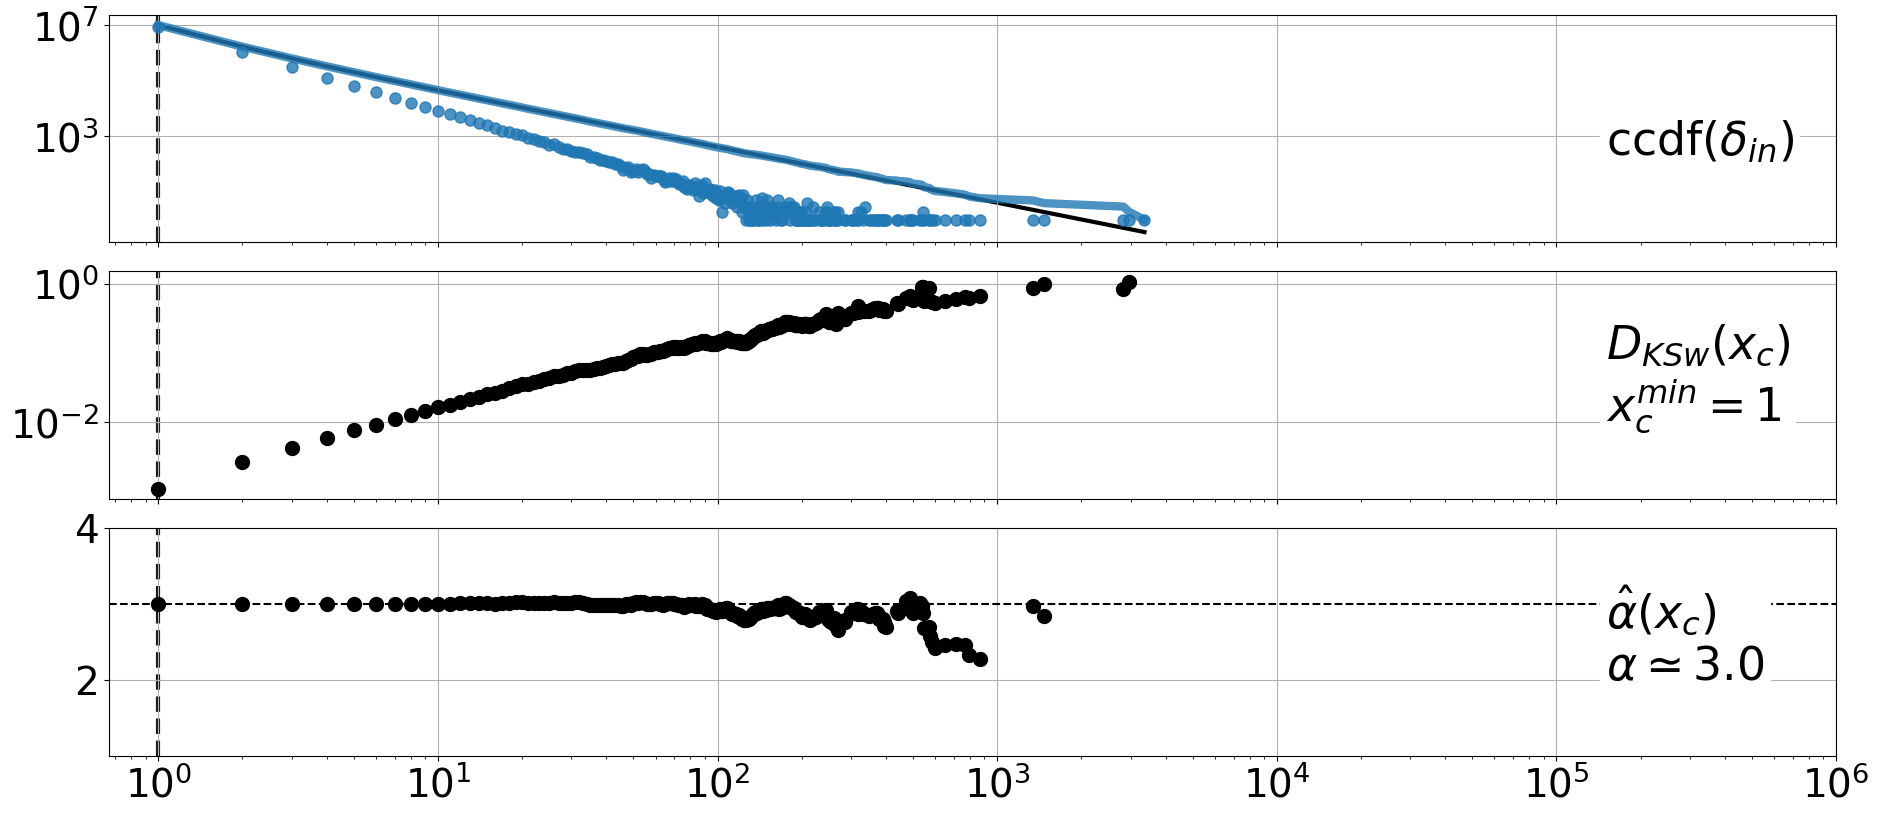

In [47]:
alpha=3
xmin=1
N=int(1e7)

x,y=zipf_distribution(alpha,xmin,N)
ccdf=np.cumsum(y[::-1])[::-1]
Plot_Figure_Degree(x,y,ccdf,yrangeAlpha=[1,4],height=4)

### Temporal Statistics of Edges

In [48]:
arraytypeBA,encodingBA,sourcearrayTSBA,targetarrayTSBA,deltaTSBA=GetEdgeTs(nodesBA,edgesBA,nodesadBA,dBA,NnodesBA,NedgesBA)

--------------------------------------------------------------------------------
Edge Source/Target TS Building  0.21 (s)
Mask Building  0.01 (s)
20,000,000 valid edges over a total of 20,000,000 i.e. 100.0 % of valid edges
--------------------------------------------------------------------------------
Building DeltaTS  0.07 (s)
Applying Mask  0.23 (s)
Building edge type array and applying mask 0.03 (s)
--------------------------------------------------------------------------------


Start for edge type : O>O
--------------------------------------------------------------------------------


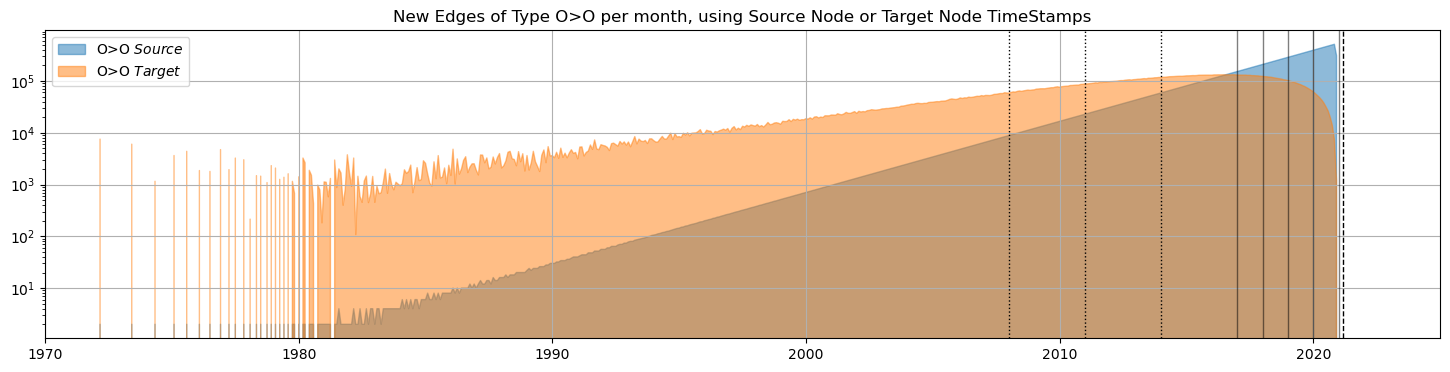

             TS <= -10 Years               0 i.e   0.00 %
-10 Years <  TS <= - 1 Year                3 i.e   0.00 %
- 1 Year  <  TS <= - 1 Month               0 i.e   0.00 %
- 1 Month <  TS <= - 1 Week                0 i.e   0.00 %
- 1 Week  <  TS <= - 1 Day                 0 i.e   0.00 %
- 1 Day   <  TS <= - 1 Hour                0 i.e   0.00 %
- 1 Hour  <  TS <= - 1 Mn                  0 i.e   0.00 %
- 1 Mn    <  TS <= - 1 S                   0 i.e   0.00 %
................................................................................
O>O     Total TS <  0 S (negative)               3 i.e   0.00 %
................................................................................
O>O     ***** TS == 0 S (null)                   0 i.e   0.00 %
................................................................................
O>O     Total TS >  0 S (positive)      19,999,997 i.e 100.00 %
................................................................................
  1 S     <= TS <   

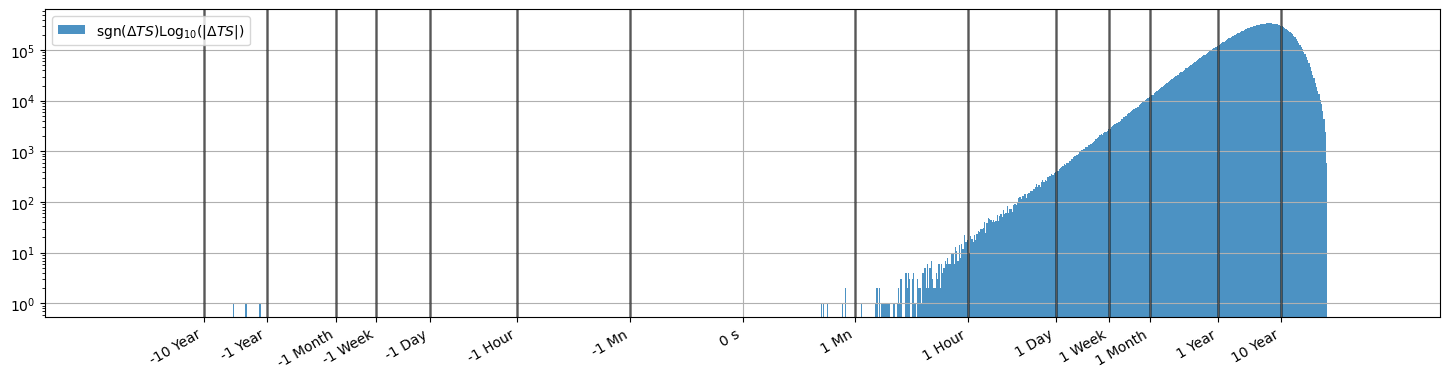

End for edge type : O>O
--------------------------------------------------------------------------------


In [50]:
for i,Etype in enumerate(encodingBA):
    mask_type=arraytypeBA==i 
    if np.sum(mask_type)!=0: # only for edge types that exist
        print("Start for edge type :",Etype)
        print(80*"-")
        PlotTSoverTimeEdges(sourcearrayTSBA[mask_type],targetarrayTSBA[mask_type],Etype)
        DisplayTSstat(deltaTSBA[mask_type],Etype)
        PlotTSHisto(deltaTSBA[mask_type],Etype)
        print(80*"-")


### Comparision between synthetic and derived datasets

In [52]:
# Derived O-(RL/RV)-O graph
nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName =LoadAllArray_OO()
arraytypeOO,encodingOO,_,_,deltaTSOO=GetEdgeTs(nodes,edges,nodesad,d,Nnodes,Nedges)
print('Unvalid edges are mainly orgin nodes without release or revision nodes after partitioning for which nodesad=2^32-1')


Loaded : nodes_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : edges_o_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : nodesadderived_derived_O-RVRL-O_BigO_20240429.pkl
Loaded : ./ImportData/d_o_derived_O-RVRL-O_BigO_20240429.pkl
DatasetName SWH derived O-[RV/RL]-O
DatasetDescription Zenodo Deposit 10.5281/zenodo.15260640
DatasetDoi 10.5281/zenodo.15260640
From EPOCH 1970-01-01
--------------------------------------------------------------------------------
Edge Source/Target TS Building  2.1 (s)
Mask Building  0.16 (s)
95,293,525 valid edges over a total of 156,682,302 i.e. 60.82 % of valid edges
--------------------------------------------------------------------------------
Building DeltaTS  1.29 (s)
Applying Mask  1.04 (s)
Building edge type array and applying mask 0.72 (s)
--------------------------------------------------------------------------------
Unvalid edges are mainly orgin nodes without release or revision nodes after partitioning for which nodesad=2^32-1


In [53]:
# O/RL/RV-RL/RV graph
# ! can take few minutes (should be less than 10mn)
nodes,edges,nodesad,d,Nnodes,Nedges,EPOCH,DatasetName =LoadAllArray()
arraytype,encoding,_,_,deltaTS=GetEdgeTs(nodes,edges,nodesad,d,Nnodes,Nedges)

Loaded : ./ImportData/nodes_20240310.pkl
Loaded : ./ImportData/edges_20240310.pkl
Loaded : ./ImportData/nodesad_20240310.pkl
Loaded : ./ImportData/d_20240310.pkl
DatasetName SWH derived (O/RL/RV)-(RL/RV)
DatasetDescription Zenodo Deposit 10.5281/zenodo.15260640
DatasetDoi 10.5281/zenodo.15260640
From EPOCH 1970-01-01
--------------------------------------------------------------------------------
Edge Source/Target TS Building  62.24 (s)
Mask Building  5.91 (s)
2,124,356,958 valid edges over a total of 3,841,679,043 i.e. 55.3 % of valid edges
--------------------------------------------------------------------------------
Building DeltaTS  10.48 (s)
Applying Mask  32.92 (s)
Building edge type array and applying mask 21.86 (s)
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Start for edge type : O>O model  Modified Barabási-Albert/Price model


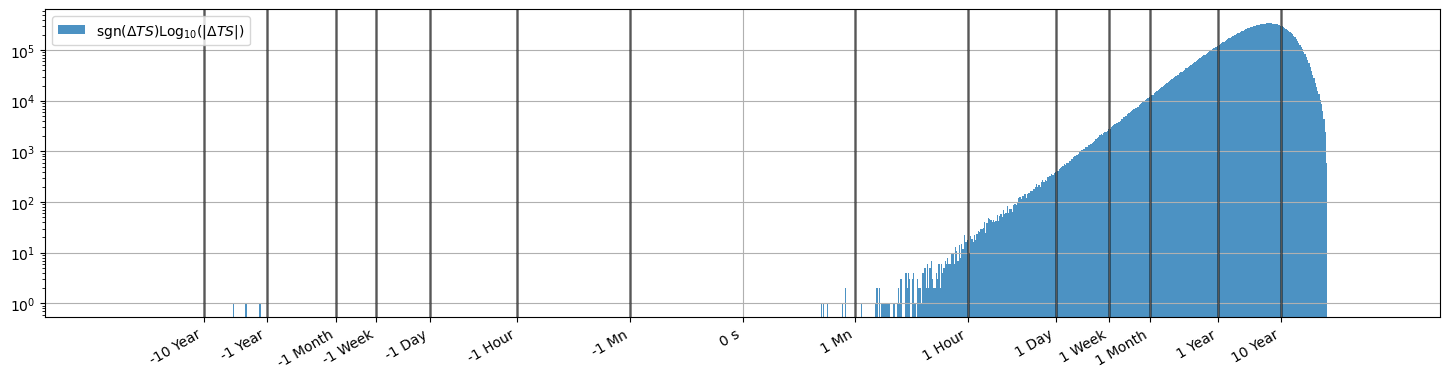

End for edge type : O>O Modified Barabási-Albert/Price model
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Start for edge type : O>O model  Derived O-(RL/RV)-O graph


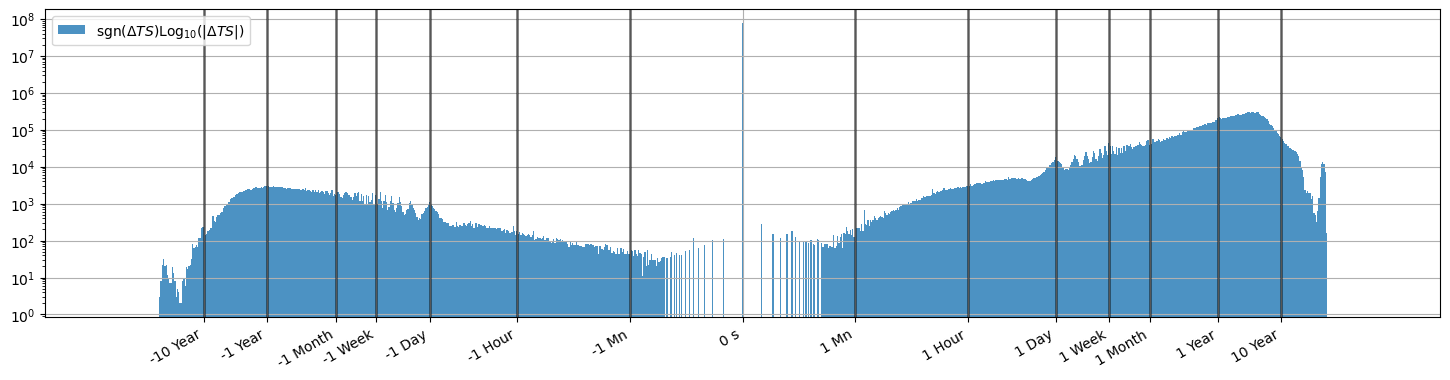

End for edge type : O>O Derived O-(RL/RV)-O graph
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Start for edge type : RV>RV model  O/RL/RV-RL/RV graph


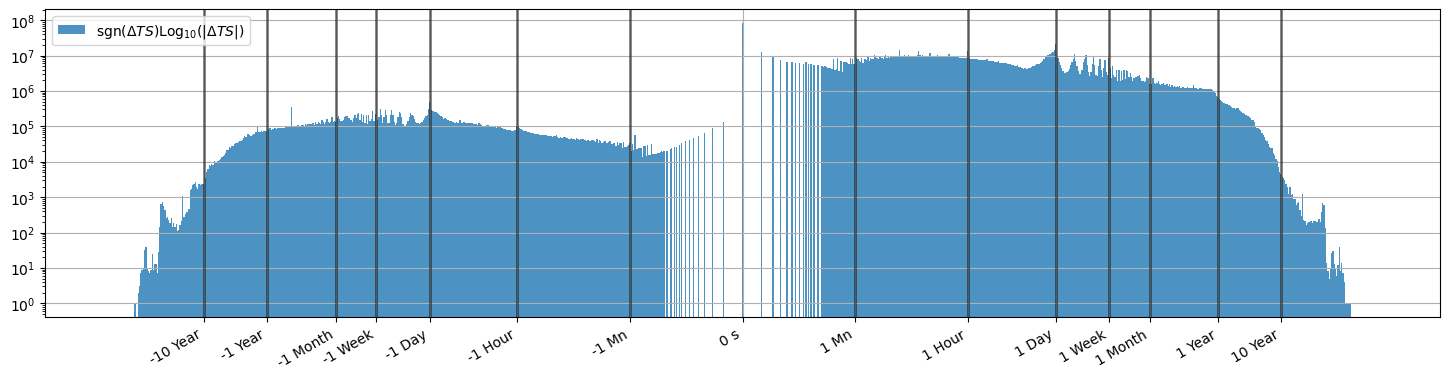

End for edge type : RV>RV O/RL/RV-RL/RV graph
--------------------------------------------------------------------------------


In [55]:
for encodingTmp,arraytypeTmp,deltaTSTmp,EtypeTmp,model in [
    (encodingBA,arraytypeBA,deltaTSBA,'O>O',' Modified Barabási-Albert/Price model'),
    (encodingOO,arraytypeOO,deltaTSOO,'O>O',' Derived O-(RL/RV)-O graph'),
    (encoding,arraytype,deltaTS,'RV>RV',' O/RL/RV-RL/RV graph'),
]:
    i=np.where(np.array(encodingTmp)==EtypeTmp)[0][0]
    mask_type=arraytypeTmp==i 
    print(80*"-")
    print("Start for edge type :",EtypeTmp,"model",model)
    PlotTSHisto(deltaTSTmp[mask_type],EtypeTmp+model)
    print(80*"-")

The comparison between these figures highlights several differences between the evolution rules of the $RV–RV$ subgraph and the derived temporal graph $O–(RL/RV)–O$ studied here, and those of the modified Barabási–Albert (Price) model.

In particular, we observe the presence or absence of:
- Edges where the source node appeared before the target node (with the exception of the three initialization edges in the Barabási–Albert model),
- Local extrema in edge density at specific timeshift values, which may reflect heterogeneous edge formation probabilities conditioned on the relative age of the connected nodes,
- Self-loops,
- Edges connecting nodes whose appearance dates differ by a duration comparable to the overall age of the system.